# Task B: BiLSTM Model - Model Evaluation
This notebook evaluates the trained model using the provided development dataset.

The following evaluation metrics and visualizations are included:
- Accuracy and Loss
- Precision and Recall
- F1 Score
- Visusalisation of Confusion Matrix
- ROC and Precision-Recall Curve
- F1 Score per class
- Accuracy per class

*_Note: Please ensure to download trained model and load tokenizer file._*

# Installing Required Packages

In [ ]:
!pip install nltk

# Data Loading and NLTK Setup

Loading in development dataset for evaluation and downloading neccesary nltk packages for preprocessing.

In [ ]:
import nltk
import pandas as pd
nltk.download('punkt_tab')
nltk.download('wordnet')

df_dev = pd.read_csv('/content/dev.csv')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Text Preprocessing for Premises and Hypotheses

This step cleans the text data for both the premise and hypothesis columns in the dataset.

## Preprocessing Pipeline Includes:
- Lowercasing the text
- Removing non-alphabetic characters
- Tokenising using NLTK's word_tokenize
- Lemmatising using WordNetLemmatizer

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import re

lemmatizer = WordNetLemmatizer()

#Preprocess the data
def preprocessing(texts):
    preprocessed_texts = []

    for text in texts:
        if not text:  #handle empty text
            continue

        #clean the text: lowercase, strip whitespace, and remove non-alphabetic characters
        cleaned_text = re.sub(r'[^A-Za-z\s]', '', text.lower().strip())

        #tokenise the cleaned text
        tokenized_words = [word for word in word_tokenize(cleaned_text)]

        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenized_words]

        #append the lemmatized words to the list
        preprocessed_texts.append(lemmatized_words)

    return preprocessed_texts

premise_dev = preprocessing(df_dev['premise'])
hypothesis_dev = preprocessing(df_dev['hypothesis'])
label_dev = df_dev['label'].values

# Prepare Development Data for Evaluation
In this step, the preprocessed premise and hypothesis texts are converted into padded sequences of integers.

## What This Step Does:
###  Tokenisation
- We load the tokeniser file obtained from training the model. This is to ensure consistency and guarantees that words are mapped to the same indices.
- The tokenised texts are then converted into sequences of integers.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

premise_dev_seq = tokenizer.texts_to_sequences(premise_dev)
hypothesis_dev_seq = tokenizer.texts_to_sequences(hypothesis_dev)

### Padding Sequences
- During training, we calculated the maximum sequence length (max_len) across the training data to standardise input shapes for the model. This value must remain consistent during evaluation to ensure that the input shapes match the model's expected dimensions.
-We then use pad_sequences to pad each sequence to this length using 'post' padding.

In [ ]:
max_len = 281

premise_dev_pad = pad_sequences(premise_dev_seq, maxlen=max_len, padding='post')
hypothesis_dev_pad = pad_sequences(hypothesis_dev_seq, maxlen=max_len, padding='post')

# Model Evaluation and Prediction for Development Data
After training and saving the best model, we reload it to evaluate performance on the development (dev) dataset. The steps involved are as follows:
 1. Load the Trained Model: We use load_model() with custom_objects to handle the custom Lambda layer (abs_diff) used in our architecture.
2. Evaluate on Dev Set: We evaluate the model using model.evaluate() to obtain the final accuracy and loss on the dev set.
 3. Predict Probabilities: The model outputs probabilities via the sigmoid activation, which are then thresholded to convert them into binary labels (0 or 1).
 4. Optimise Threshold using MCC: Instead of defaulting to a threshold of 0.5, we find the optimal threshold by maximizing the Matthews Correlation Coefficient (MCC) — a balanced metric even for imbalanced data.
 5. Generate Predictions: Using the best threshold, we convert probabilities to final binary predictions.
 6. Save Predictions: Predicted labels are saved to a CSV file (dev_predictions.csv) for reporting or further analysis.
 7. We display a full classification report and key performance metrics:

   - Precision

   - Recall

    - F1 Score

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

def abs_diff(x):
    return K.abs(x)

#load model
model = load_model("best_nli_model_B.keras", custom_objects={'abs_diff': abs_diff})

loss, acc = model.evaluate([premise_dev_pad, hypothesis_dev_pad], label_dev)
print(f"Final Dev Accuracy: {acc:.4f}")
print(f"Final Dev Loss    : {loss:.4f}")

#predicting dev data labels
preds = model.predict([premise_dev_pad, hypothesis_dev_pad])

best_mcc = -1
best_thresh = 0.5

for t in np.arange(0.1, 0.9, 0.01):
    pred_labels_temp = (preds > t).astype(int)
    mcc = matthews_corrcoef(label_dev, pred_labels_temp)
    if mcc > best_mcc:
        best_mcc = mcc
        best_thresh = t

#use best threshold for final prediction
pred_labels = (preds > best_thresh).astype(int)
print("Best Threshold:", best_thresh)

print("Predictions:", pred_labels[:10].flatten())
print("Ground Truth:", label_dev[:10])

#save predictions to CSV
prediction_df = pd.DataFrame({'prediction': pred_labels.flatten()})
prediction_df.to_csv("dev_predictions.csv", index=False)

#classification metrics
print("\nClassification Report:")
print(classification_report(label_dev, pred_labels))

precision = precision_score(label_dev, pred_labels)
recall = recall_score(label_dev, pred_labels)
f1 = f1_score(label_dev, pred_labels)

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.6646 - loss: 0.6219
Final Dev Accuracy: 0.6770
Final Dev Loss    : 0.6114
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
Best Threshold: 0.48999999999999977
Predictions: [1 0 0 0 1 1 1 0 0 1]
Ground Truth: [0 1 1 0 1 1 1 1 0 0]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3258
           1       0.66      0.76      0.71      3478

    accuracy                           0.68      6736
   macro avg       0.68      0.68      0.67      6736
weighted avg       0.68      0.68      0.68      6736

Precision : 0.6644
Recall    : 0.7628
F1 Score  : 0.7102


# Visualise Confusion Matrix
To gain a better understanding of how well the model distinguishes between the two classes (entailment vs non-entailment), we plot a confusion matrix using the final predicted labels.

## What It Shows:
- True Positives (TP): Correctly predicted entailments
- True Negatives (TN): Correctly predicted non-entailments
- False Positives (FP): Non-entailments incorrectly predicted as entailments
- False Negatives (FN): Entailments incorrectly predicted as non-entailments

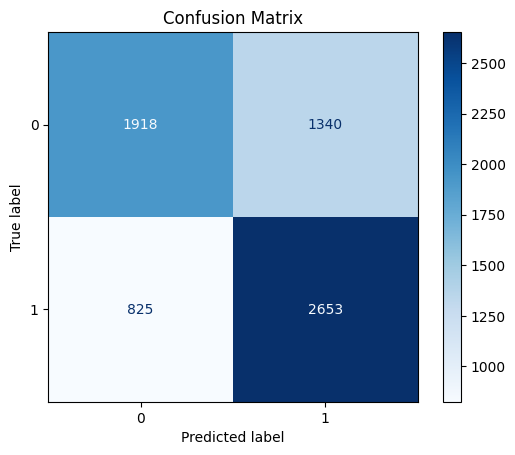

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(label_dev, pred_labels)

#plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Plot the ROC Curve
The Receiver Operating Characteristic (ROC) curve is a graphical representation of a classifier's performance across various classification thresholds.

## What It Shows:
- True Positive Rate (TPR) vs. False Positive Rate (FPR)
- How well the model distinguishes between classes
- The Area Under the Curve (AUC) provides a single number summary:
 - AUC = 1.0: Perfect classifier
 - AUC = 0.5: No discrimination (random guess)

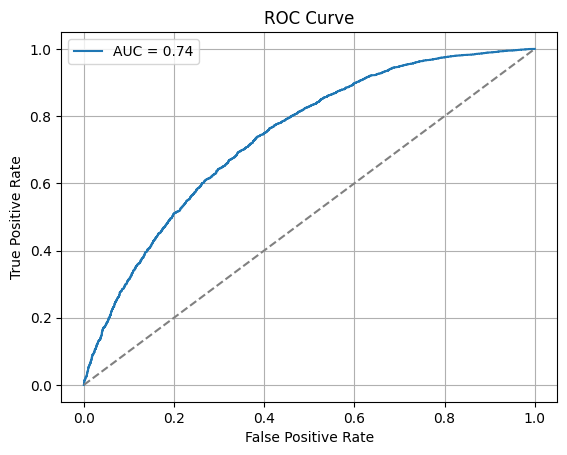

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(label_dev, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


#Plot the Precision-Recall Curve
The Precision-Recall (PR) Curve is particularly useful for evaluating classification models on imbalanced datasets, where one class is significantly less frequent than the other.

##What It Shows:
The trade-off between precision (how many predicted positives are correct) and recall (how many actual positives are captured) at various thresholds.
The area under this curve can also be used to evaluate model performance, higher is better.

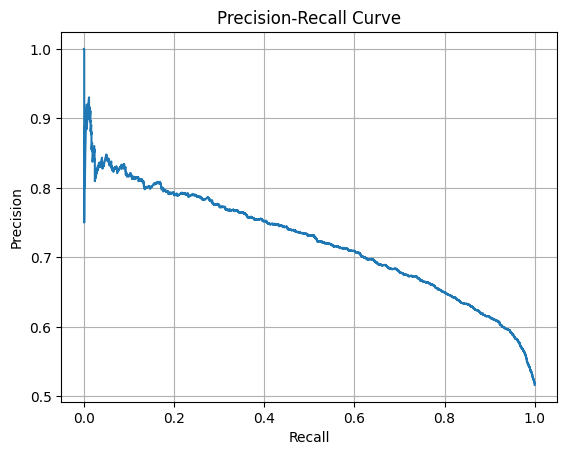

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(label_dev, preds)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


#F1 Score per Class Visualisation
To better understand class-wise performance, we compute and visualise the F1 scores for each class individually: entailment (label 1) and not_entailment (label 0).

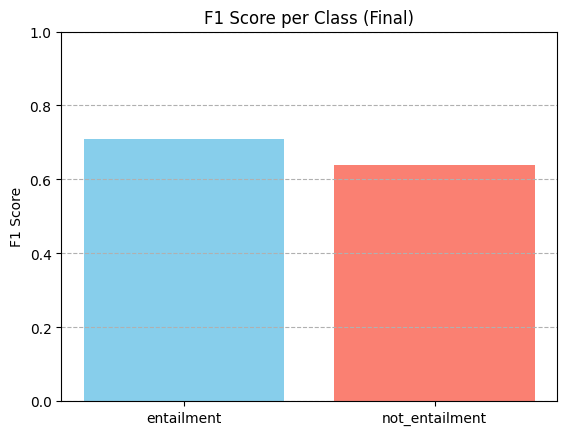

In [ ]:

f1_entail = f1_score(label_dev, pred_labels, pos_label=1)
f1_non_entail = f1_score(label_dev, pred_labels, pos_label=0)

plt.bar(['entailment', 'not_entailment'], [f1_entail, f1_non_entail], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.title('F1 Score per Class (Final)')
plt.grid(axis='y', linestyle='--')
plt.show()


#Accuracy per Class Visualisation
This plot shows the accuracy of the model for each individual class, how often it correctly predicts entailment and not_entailment.

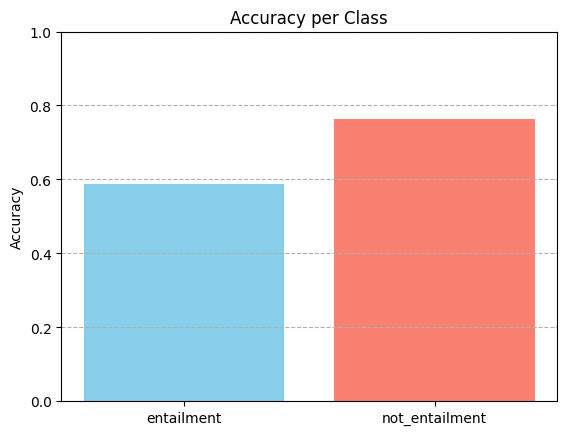

In [ ]:
cm = confusion_matrix(label_dev, pred_labels)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.bar(['entailment', 'not_entailment'], class_accuracy, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--')
plt.show()
